In [1]:
# Common imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = (10, 5)

/Users/esachko/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Альтернативные способы обучения

Стандартное обучение исходной модели (например, метод наименьших квадратов в линейной регрессии) может создавать описанные выше проблемы. Чтобы уменьшить вероятность их возникновения, применяют альтернативные способы обучения, такие как:
* обучение с выбором подмножества фич (subset selection)
* обучение с регуляризаций (shrinkage или regularization)
* обучение с уменьшением размерности фич (dimensionality reduction)

## Subset selection

Идея проста:
* создать множество моделей-кандидатов, содержащих только часть фич
* выбрать лучшего кандидата, оценив тестовую ошибку

### Best subset selection

```python
candidates = [M0]
for k in range(1, p + 1):
    pre_candidates = get_fit_models(n_features=k)  # все комбинации из p по k
    Mk = select_best_on_training(pre_candidates)
    candidates.append(Mk)
```

### Stepwise selection

Best subset selection очень дорог, хотя и гарантирует нахождение оптимального решения. Более того, чем больше $p$, тем больше вероятность найти модели, которые показывают отличные результаты на тренировочных данных и плохие на тестовых. Поэтому мы хотим сузить область поиска кандидатов.

#### Forward stepwise selection

```python
candidates = [M0]
for k in range(0, p):
    # находим модели, дополняющие предыдущую модель одной фичей
    pre_candidates = get_models_with_one_additional_feature(candidates[-1])
    Mk = select_best_on_training(pre_candidates)
    candidates.append(Mk)
```

#### Backward stepwise selection

```python
candidates = [Mp]
for k in range(p, 0, -1):
    # находим модели без одной из фич, присутствующих в candidates[-1]
    pre_candidates = get_models_without_one_feature(candidates[-1])
    Mk = select_best_on_training(pre_candidates)
    candidates.append(Mk)
```

Forward можно использовать, когда p > n, а backward - нет. Недостаток обеих моделей - их жадность:).

#### Hybrid approaches

Возможно и добавление, и удаление фич.

### Выбор лучшего кандидата

* косвенная оценка: оцениваем модели на тренировочных данных, корректируя тренировочную ошибку ($C_p$, $AIC$, $BIC$, скорректированный $R^2$)
* непосредственная оценка: оцениваем модели на validation set
    
Косвенную оценку используют, когда очень дорого делать cross-validation. 

Важно помнить, что $RSS$ и $R^2$ улучшаются каждый раз, когда мы добавляем еще один предсказатель. Поэтому использовать данные метрики для выбора лучшего кандидата при косвенной оценке нельзя (почему? а можно при непосредственной?). 

$$
C_p = \frac{1}{n}(RSS + 2d{\hat{\sigma}}^2) \\
AIC = \frac{1}{n{\hat{\sigma}}^2}(RSS + 2d{\hat{\sigma}}^2) \\
BIC = \frac{1}{n}(RSS + log(n)d{\hat{\sigma}}^2) \\
Adjusted\ R^2 = 1 - \frac{\frac{RSS}{n - d - 1}}{\frac{TSS}{n-1}} \\
d \text{ - количество предсказателей}
$$

## Shrinkage (регуляризация)

#### Линейная регрессия
$$RSS = \sum_{i=1}^n (y_i - \beta_0 - \sum_{j=1}^p \beta_j * x_{ij})^2$$
#### Ridge
$$RSS = \sum_{i=1}^n (y_i - \beta_0 - \sum_{j=1}^p \beta_j * x_{ij})^2 + \lambda \sum_{j=1}^p \beta_j^2$$
#### Lasso
$$RSS = \sum_{i=1}^n (y_i - \beta_0 - \sum_{j=1}^p \beta_j * x_{ij})^2 + \lambda \sum_{j=1}^p |\beta_j|$$

In [2]:
import os
import urllib
import shutil

def download_file(url, dir_path="data"):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        
    file_name = os.path.split(url)[-1]
    file_path = os.path.join(dir_path, file_name)
    
    with urllib.request.urlopen(url) as response, open(file_path, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)
        
    return file_path

In [3]:
download_file("http://www-bcf.usc.edu/~gareth/ISL/Advertising.csv")
adv_df = pd.read_csv('data/Advertising.csv', usecols=[1,2,3,4])
adv_df.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [4]:
from sklearn.linear_model import Ridge, Lasso

In [5]:
X = adv_df[["TV", "radio", "newspaper"]].as_matrix()
y = adv_df.sales

In [6]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [7]:
lm = LinearRegression().fit(X, y)
print(lm.intercept_)
print(lm.coef_)

2.9388893694594085
[ 0.04576465  0.18853002 -0.00103749]


/Users/esachko/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [8]:
rg = Ridge(alpha=1000).fit(X, y)
print(rg.intercept_)
print(rg.coef_)

3.015339995650555
[4.57622297e-02 1.83741986e-01 1.17620257e-04]


In [9]:
rg.coef_ - lm.coef_

array([-2.41572245e-06, -4.78803061e-03,  1.15511330e-03])

In [10]:
rg = Lasso().fit(X, y)
print(rg.intercept_)
print(rg.coef_)

3.040215583480377
[0.04566142 0.1834644  0.        ]


In [11]:
rg.coef_ - lm.coef_

array([-0.00010323, -0.00506562,  0.00103749])

## Dimensionality reduction

Трансформирует $p$ фич в $M$ линейных комбинаций этих фич, так, что $M < p$. Новые фичи ($Z_i$) используются для построения модели. Основная идея при трансформации - объяснить новыми фичами как можно больший процент вариативности (variance) исходных данных, при этом уменьшив размерность пространства.

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=X.shape[1]).fit(X)
for i in range(1, X.shape[1] + 1):
    print("n-components=%s, explained variance %.3f" % (i, sum(pca.explained_variance_ratio_[:i])))

n-components=1, explained variance 0.914
n-components=2, explained variance 0.978
n-components=3, explained variance 1.000


In [13]:
new_adv_df = pd.DataFrame(PCA(n_components=1).fit_transform(X), columns=["f1"])
new_adv_df["Sales"] = adv_df.sales
new_adv_df.head(5)

,f1,Sales
0,83.788546,22.1
1,-102.138730,10.4
2,-128.992484,9.3
3,5.070972,18.5
4,34.059003,12.9


In [14]:
pca_lm = smf.ols('Sales ~ f1', new_adv_df).fit()
rss = np.sum(pca_lm.resid ** 2)
print("RSS:", rss)
print("R^2:", pca_lm.rsquared)

RSS: 2088.630492299054
R^2: 0.6144409930964045


### PCA

Text(0,0.5,'feature 2')

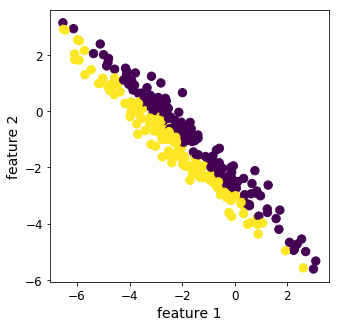

In [15]:
plt.rcParams['figure.figsize'] = 5, 5

rnd = np.random.RandomState(5)
X_ = rnd.normal(size=(300, 2))
X_blob = np.dot(X_, rnd.normal(size=(2, 2))) + rnd.normal(size=2)
y = X_[:, 0] > 0
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y, s=70) # , linewidths=0
plt.xlabel("feature 1")
plt.ylabel("feature 2")

In [16]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_blob)
X_pca = pca.transform(X_blob)

Text(0,0.5,'second principal component')

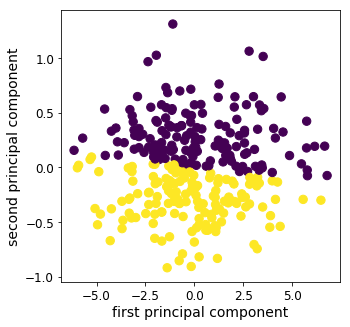

In [17]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=70) # linewidths=1, 
plt.xlabel("first principal component")
plt.ylabel("second principal component")

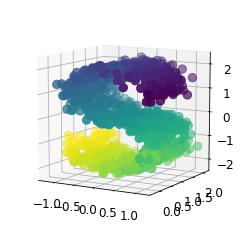

In [18]:

plt.rcParams['figure.figsize'] = 4, 4

from sklearn.datasets import make_s_curve
X, y = make_s_curve(n_samples=1000, noise=0.1)

from mpl_toolkits.mplot3d import Axes3D
ax = plt.axes(projection='3d')

ax.scatter3D(X[:, 0], X[:, 1], X[:, 2], c=y, s=70)
ax.view_init(10, -60)

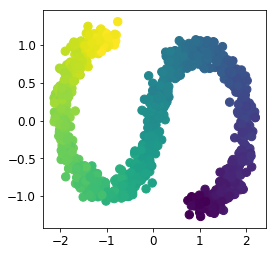

In [19]:
X_pca = PCA(n_components=2).fit_transform(X)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=70)

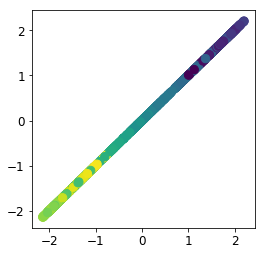

In [20]:
X_pca = PCA(n_components=1).fit_transform(X)
plt.scatter(X_pca[:, 0], X_pca[:, 0], c=y, s=70)

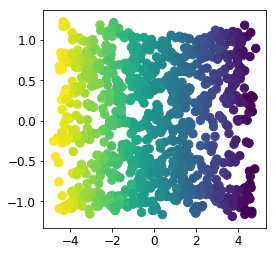

In [21]:

from sklearn.manifold import Isomap

iso = Isomap(n_neighbors=15, n_components=2)
X_iso = iso.fit_transform(X)
plt.scatter(X_iso[:, 0], X_iso[:, 1], c=y, s=70)

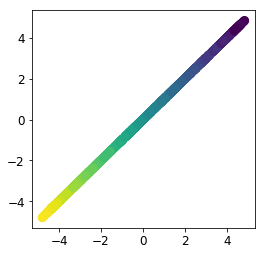

In [22]:

from sklearn.manifold import Isomap

iso = Isomap(n_neighbors=15, n_components=1)
X_iso = iso.fit_transform(X)
plt.scatter(X_iso[:, 0], X_iso[:, 0], c=y, s=70)